<a href="https://colab.research.google.com/github/afsalmuhd/ML-ict-ul_cyberpark/blob/main/day5_movie_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from bs4 import BeautifulSoup
import string
from collections import Counter
from wordcloud import WordCloud
from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Book1.csv", encoding="latin-1")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
144,"I just got back from this free screening, and ...",negative
145,I remember seeing this film in the theater in ...,positive
146,A family is traveling through the mid West. Th...,positive
147,Francis Ford Coppola wrote and directed this s...,positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     149 non-null    object
 1   sentiment  149 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [5]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Apply function to dataset
df["review"] = df["review"].apply(remove_html_tags)

In [6]:
df["review"] = df["review"].str.replace("[^a-zA-Z]", " ", regex=True)

# Remove extra spaces
df["review"] = df["review"].str.replace("\s+", " ", regex=True).str.strip()

In [7]:
punctuation_pattern = f"[{string.punctuation}]"
df["review"] = df["review"].str.replace(punctuation_pattern, "", regex=True)

In [8]:
#lower case
df["review"] = df["review"].str.lower()
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is a...,positive
...,...,...
144,i just got back from this free screening and t...,negative
145,i remember seeing this film in the theater in ...,positive
146,a family is traveling through the mid west the...,positive
147,francis ford coppola wrote and directed this s...,positive


In [9]:
#missing value
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
import nltk
nltk.download('punkt')

In [13]:
#tokenization
df["review"] = df["review"].apply(word_tokenize)

In [14]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def remove_stop_words(token_list):
    return [word for word in token_list if word not in stop_words]

df["review"] = df["review"].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
def stem_tokens(token_list):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in token_list]

df["review"] = df["review"].apply(stem_tokens)

In [16]:
all_tokens = [token for sublist in df["review"] for token in sublist]
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)
most_common_words

[('movi', 317),
 ('film', 291),
 ('one', 141),
 ('like', 125),
 ('get', 88),
 ('see', 86),
 ('good', 85),
 ('make', 84),
 ('time', 81),
 ('even', 81),
 ('stori', 78),
 ('scene', 74),
 ('would', 73),
 ('watch', 67),
 ('charact', 66),
 ('go', 61),
 ('realli', 58),
 ('act', 58),
 ('way', 55),
 ('much', 55)]

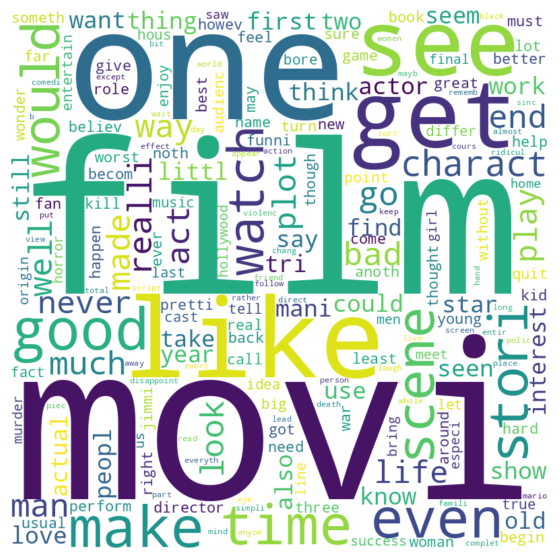

In [17]:
# Visualize it using wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide the axes
plt.show()

In [18]:
# Join the tokens back into strings for the vectorizer
df["joined_review"] = df["review"].apply(" ".join)
text_data = df["joined_review"]
tfidf_vectorizer = TfidfVectorizer(max_features=2000)

# Fit the vectorizer to the text data and transform it into TF-IDF features
x_tfidf = tfidf_vectorizer.fit_transform(text_data)
x_tfidf

<149x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 11307 stored elements in Compressed Sparse Row format>

In [19]:
df["sentiment_numeric"] = df["sentiment"].map({"positive": 1, "negative": 0})

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x_tfidf, df["sentiment_numeric"], test_size=0.2, random_state=1)

In [20]:
# Scale data
scaler = MaxAbsScaler()

# Scale the training and test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [21]:
# Train MLP model
mlp_model = MLPClassifier()
mlp_model.fit(x_train_scaled, y_train)

MLPClassifier()

In [22]:
# Evaluate the Model
y_pred = mlp_model.predict(x_test_scaled)

# Calculate accuracy
mlp_accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {mlp_accuracy}")

# Print classification report for a detailed performance analysis
print(classification_report(y_test, y_pred))

Model accuracy: 0.6
              precision    recall  f1-score   support

           0       0.47      0.82      0.60        11
           1       0.82      0.47      0.60        19

    accuracy                           0.60        30
   macro avg       0.65      0.65      0.60        30
weighted avg       0.69      0.60      0.60        30



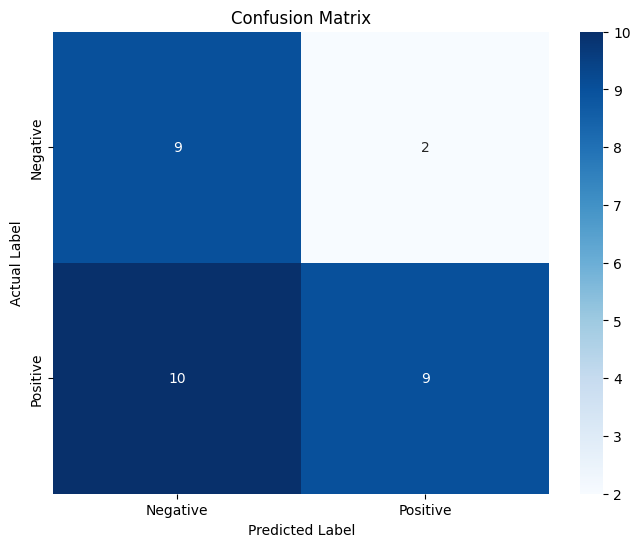

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [24]:
# Define a function to get all scores
def get_scores(y_true, y_pred_prob, threshold=0.5):

    y_pred = (y_pred_prob[:, 1] >= threshold).astype(int)

    scores = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'Roc_Auc': roc_auc_score(y_true, y_pred_prob[:, 1])
    }

    return scores

y_pred_mlp_prob = mlp_model.predict_proba(x_test_scaled)

# Now call the function with the true labels and the predicted probabilities
scores_mlp = get_scores(y_test, y_pred_mlp_prob)
scores_mlp

{'Accuracy': 0.6,
 'Precision': 0.8181818181818182,
 'Recall': 0.47368421052631576,
 'F1': 0.6,
 'Roc_Auc': 0.784688995215311}

In [25]:
# Sample text to predict sentiment
sample_text = [
    "This movie was a great watch with brilliant performances and a gripping plot!",  # Positive
    "An absolute waste of time, the worst movie I've seen in a long while.",  # Negative
    "I found the movie to be mediocre, not terrible but not great either.",  # Neutral
    "The cinematography was stunning, but the storyline was lacking and unoriginal.",  # Neutral/Negative
    "The film was a masterpiece with a perfect blend of drama and action, a must-watch!",  # Positive
    "It was an okay movie; I neither liked it nor disliked it particularly.",  # Neutral
    "The plot twist at the end was predictable and uninspired.",  # Negative
    "A stellar cast, but the film fell flat due to poor writing.",  # Negative
    "I loved the special effects, but the characters were not very compelling.",  # Neutral/Negative
    "The movie was well-received by critics but I didn't find it very interesting.",  # Neutral
    "This film is overrated, I had high expectations but was sadly disappointed.",  # Negative
    "What an entertaining experience, I was on the edge of my seat the whole time!"  # Positive
]

for text in sample_text:
    # Convert the text to TF-IDF features
    sample_tfidf = tfidf_vectorizer.transform([text])

    # Scale the features because we scaled during training
    sample_scaled = scaler.transform(sample_tfidf)

    # Make a prediction
    prediction_prob = mlp_model.predict_proba(sample_scaled)

    # Get the predicted probability of the positive class
    positive_prob = prediction_prob[0, 1]

    # Apply threshold to convert probabilities to class labels
    prediction = 1 if positive_prob > 0.5 else 0

    # Output the prediction
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"{text} ->  {sentiment}")
    # print(f"Predicted sentiment: {sentiment}")

This movie was a great watch with brilliant performances and a gripping plot! ->  Negative
An absolute waste of time, the worst movie I've seen in a long while. ->  Negative
I found the movie to be mediocre, not terrible but not great either. ->  Positive
The cinematography was stunning, but the storyline was lacking and unoriginal. ->  Positive
The film was a masterpiece with a perfect blend of drama and action, a must-watch! ->  Negative
It was an okay movie; I neither liked it nor disliked it particularly. ->  Negative
The plot twist at the end was predictable and uninspired. ->  Negative
A stellar cast, but the film fell flat due to poor writing. ->  Negative
I loved the special effects, but the characters were not very compelling. ->  Negative
The movie was well-received by critics but I didn't find it very interesting. ->  Positive
This film is overrated, I had high expectations but was sadly disappointed. ->  Positive
What an entertaining experience, I was on the edge of my seat